<a href="https://colab.research.google.com/github/gustafbjurstam/ML-retreat-tekmek-2025/blob/main/unsupervised-learning-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PCA and unsupervised learning

In this lesson we will be learning about *unsupervised learning*. This means that the computer has to work something out about data without knowing the correct answer to any data points a priori. Generally we say that there are three broad areas, clustering, anomaly detection, and dimensionality reduction.

The methods we will examine in each category are

- Dimensionality reduction
    - Principal Component Analysis (PCA)
    - Sparse PCA
- Clustering / Unsupervised classification
    - K-means
    - Hierarchical clustering with dendrograms
    - Graph based clustering
        - ɛ-neigbourhood
        - k-Nearest-Neighbours
        - Spectral clustering
- Anomaly detection
    - k-Nearest-Neighbours
    - One-Class Support Vector Machines


# Dimensionality reduction

High fidelity measurements in engineering often produce vectors with hundreds or thousands of degrees of freedom, yet the dominant behavior is driven by a small number of patterns. **Dimensionality reduction** finds those low rank coordinates. By projecting data onto a smaller subspace we obtain a tractable description, filter noise, and reveal structure that is hard to see in the raw variables. Importantly, this is done **without labels**: the directions are inferred from statistical regularities in the snapshots.

Classical principal component analysis (PCA) looks for orthogonal directions of maximum variance and yields dense modes that combine information from many sensors. Sparse PCA adds a sparsity penalty so that each mode uses only a few locations, improving interpretability at a small cost in captured variance. Both are linear, transparent, and fast.

---

# The flow dataset we use

We work with a time series of a **2D, incompressible, unsteady double gyre** velocity field on a uniform Cartesian grid, augmented with a multi scale stochastic perturbation. Each snapshot contains the two components
$$
u(x,y,t), \quad v(x,y,t),
$$
and our PCA is performed on the **stacked vector field** $[u \mid v]$.

**Domain and base flow**
- Spatial domain: $x \in [0,2]$, $y \in [0,1]$.
- The base flow is given by the streamfunction
$$
\psi(x,y,t) \;=\; A \,\sin\big(\pi\, f(x,t)\big)\, \sin(\pi y),
$$
with
$$
f(x,t) \;=\; a(t)\,x^2 \;+\; b(t)\,x, \qquad
a(t) \;=\; \varepsilon \sin(\omega t), \quad b(t) \;=\; 1 - 2\varepsilon \sin(\omega t).
$$
Velocities follow from $\mathbf{u}=(u,v)=(\partial_y \psi,\,-\partial_x \psi)$.

**Engineering relevance**
- The double gyre is a clean proxy for **recirculating cells and transport barriers**, which appear in cavity flows, stirred tanks, and environmental/oceanic flows (e.g., mesoscale eddies). It is widely used to study **mixing, coherent structures, and Lagrangian transport**.
- Its controlled unsteadiness makes it an excellent testbed for dimensionality reduction: a few modes capture the dominant sway of the gyres while higher modes capture smaller scale content.

**Why it is asymmetric**
- When $\varepsilon > 0$, the coefficients $a(t)$ and $b(t)$ vary with $\sin(\omega t)$. This shifts the separatrix and the vortex centers horizontally, so the two gyres are **not mirror symmetric** at most times. Symmetry is approximately restored when $\sin(\omega t)=0$ (i.e., $a(t)=0$ and $b(t)=1$).
- We also add a stochastic perturbation that further breaks symmetry in each snapshot.

**Perturbation: multi scale noise and a simple knob**
- We superimpose a fractional Brownian motion (fBm) field on $u$ and $v$ to mimic unresolved small scale effects.
- A single parameter
$$
\texttt{perturbation_strength} \in \mathbb{R}^+
$$
scales the perturbation amplitude. Increasing it injects more small scale variation and pushes energy into higher PCA modes; decreasing it yields a cleaner, nearly rank 1 dataset.

**What we feed to PCA**
- For each time $t_k$, we flatten $u(x,y,t_k)$ and $v(x,y,t_k)$, then form a row
$$
x_k \;=\; \big[u(x_1,y_1,t_k),\ldots,u(x_N,y_N,t_k)\,\mid\,v(x_1,y_1,t_k),\ldots,v(x_N,y_N,t_k)\big].
$$
- The snapshot matrix $X \in \mathbb{R}^{T \times 2N}$ is centered in time, then factorized by SVD to obtain spatial modes and temporal coefficients.



In [1]:
#@title Generator functions and other utilities (run but no need to see)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # Import for Colab display
import time

# --- (Self-contained noise generation function) ---
def generate_perlin_fbm(shape, res, octaves=4, persistence=0.5, lacunarity=2.0, seed=0):
    """
    Generates a 3D Fractional Brownian Motion field using vectorized Perlin noise.
    No external libraries needed beyond NumPy.
    """
    rng = np.random.default_rng(seed)
    noise = np.zeros(shape)
    frequency = 1.0
    amplitude = 1.0

    for _ in range(octaves):
        # Create grid points and random gradients
        # FIX IS HERE: Ensure the resolution for the noise grid is at least 1,
        # which makes the gradient grid size at least 2.
        t_res, y_res, x_res = (max(1, int(r * frequency)) for r in res)

        grid_shape = (t_res + 1, y_res + 1, x_res + 1)

        gradients = rng.uniform(-1, 1, size=(*grid_shape, 3))
        gradients /= np.linalg.norm(gradients, axis=-1, keepdims=True)

        # Create coordinates for each point in the output shape
        t_coords, y_coords, x_coords = np.meshgrid(
            np.linspace(0, t_res, shape[0], endpoint=False),
            np.linspace(0, y_res, shape[1], endpoint=False),
            np.linspace(0, x_res, shape[2], endpoint=False),
            indexing='ij'
        )

        # Calculate grid indices and local coordinates
        t0, y0, x0 = t_coords.astype(int), y_coords.astype(int), x_coords.astype(int)
        t, y, x = t_coords - t0, y_coords - y0, x_coords - x0

        # Smoothstep function for interpolation weights
        def fade(t): return t * t * t * (t * (t * 6 - 15) + 10)
        wt, wy, wx = fade(t), fade(y), fade(x)

        # Calculate dot products with gradients at the 8 corners of the cube
        noise_val = np.zeros(shape)
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    grad = gradients[t0 + i, y0 + j, x0 + k]
                    dot_prod = grad[..., 0] * (t - i) + grad[..., 1] * (y - j) + grad[..., 2] * (x - k)

                    # Interpolate
                    interp_weight = (wt if i == 1 else 1 - wt) * \
                                    (wy if j == 1 else 1 - wy) * \
                                    (wx if k == 1 else 1 - wx)
                    noise_val += dot_prod * interp_weight

        noise += noise_val * amplitude
        amplitude *= persistence
        frequency *= lacunarity

    return noise

def generate_perturbed_gyre_data(
    grid_res=20,       # Resolution of the spatial grid
    n_snapshots=200,   # Number of time steps
    A=0.1,             # Gyre velocity magnitude
    epsilon=0.25,      # Gyre oscillation amplitude
    omega=2 * np.pi / 10, # Gyre oscillation frequency

    # --- Perturbation Field Parameters ---
    perturbation_strength=0.4,
    noise_scale=12.0,
    octaves=4,
    persistence=0.5,
    lacunarity=2.0,
    time_scale=0.5
):
    """
    Generates a Double Gyre dataset with a synthesized stochastic perturbation field.
    """
    # 1. Define Spatial and Temporal Grid
    x_points = np.linspace(0, 2, grid_res * 2); y_points = np.linspace(0, 1, grid_res)
    xx, yy = np.meshgrid(x_points, y_points)
    t_space = np.linspace(0, 20, n_snapshots)

    # 2. Generate the entire 3D (time, y, x) noise fields in one go
    shape_3d = (n_snapshots, grid_res, grid_res * 2)
    res_3d = (t_space.size*time_scale/10, y_points.size*noise_scale/100, x_points.size*noise_scale/100)

    print("Generating 3D noise field for u_perturb...")
    u_perturb_3d = generate_perlin_fbm(shape_3d, res_3d, octaves, persistence, lacunarity, seed=42)
    print("Generating 3D noise field for v_perturb...")
    v_perturb_3d = generate_perlin_fbm(shape_3d, res_3d, octaves, persistence, lacunarity, seed=99)

    snapshot_data = []
    for i, t in enumerate(t_space):
        # 3. Calculate base gyre flow for the current time step
        a_t = epsilon * np.sin(omega * t); b_t = 1 - 2 * epsilon * np.sin(omega * t)
        f_x_t = a_t * xx**2 + b_t * xx; df_dx = 2 * a_t * xx + b_t
        u_gyre = -np.pi * A * np.sin(np.pi * f_x_t) * np.cos(np.pi * yy)
        v_gyre = np.pi * A * np.cos(np.pi * f_x_t) * np.sin(np.pi * yy) * df_dx

        # 4. Combine the base flow and the perturbation
        u_total = u_gyre + perturbation_strength * A * u_perturb_3d[i]
        v_total = v_gyre + perturbation_strength * A * v_perturb_3d[i]
        speed = np.sqrt(u_total**2 + v_total**2)
        snapshot_data.append(speed.flatten())

    return np.array(snapshot_data), xx, yy

def animate_flow(data_matrix, xx, yy, title_prefix, vmin, vmax):
    """Creates a matplotlib animation object for the given flow data."""
    fig, ax = plt.subplots(figsize=(10, 5))
    grid_shape = xx.shape
    initial_frame = data_matrix[0, :].reshape(grid_shape)
    quad_mesh = ax.pcolormesh(xx, yy, initial_frame, cmap='inferno', vmin=vmin, vmax=vmax, shading='gouraud')
    fig.colorbar(quad_mesh, ax=ax, label='Flow Speed')

    def update(frame):
        ax.cla()
        speed_field = data_matrix[frame, :].reshape(grid_shape)
        ax.pcolormesh(xx, yy, speed_field, cmap='inferno', vmin=vmin, vmax=vmax, shading='gouraud')
        ax.set_title(f"{title_prefix} (Frame: {frame})")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal', 'box')

    ani = FuncAnimation(fig, update, frames=data_matrix.shape[0], interval=50, blit=False)
    plt.close(fig)
    return ani

Change the value of the variable `perturbation_strength` to adjust the level of noise.

In [3]:
perturbation_strength = 0.4 # Noise level

Generating Perturbed Double Gyre data...
Generating 3D noise field for u_perturb...
Generating 3D noise field for v_perturb...
Reconstructing perturbation fields to match generator seeds...


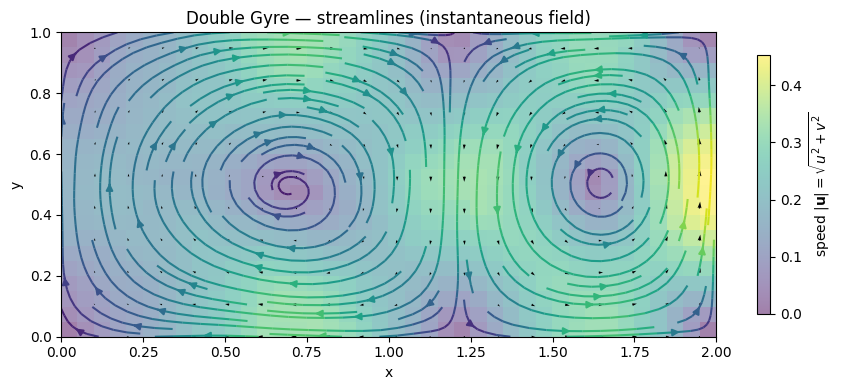

In [4]:
#@title Run for data generation and visualisation
# MARCO
# 1. Generate and visualise data  — REVISED (keep generation, replace visualisation)
print("Generating Perturbed Double Gyre data...")
X_speed, xx, yy = generate_perturbed_gyre_data()   # ← unchanged

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display

# --- Parameters must match your generator defaults ---
A = 0.1
epsilon = 0.25
omega = 2 * np.pi / 10.0
# perturbation_strength = 0.7# was 0.4
noise_scale = 12.0
octaves = 4
persistence = 0.5
lacunarity = 2.0
time_scale = 0.5

# --- Rebuild the perturbed velocity field (u_total, v_total) to MATCH X_speed ---
# We replicate exactly what happens inside generate_perturbed_gyre_data(),
# but this time we KEEP u and v so we can visualise vectors/streamlines.
ny, nx = yy.shape
n_snapshots = X_speed.shape[0]
x_points = xx[0, :]
y_points = yy[:, 0]
t_space = np.linspace(0, 20, n_snapshots)

shape_3d = (n_snapshots, ny, nx)
res_3d = (t_space.size * time_scale / 10,
          y_points.size * noise_scale / 100,
          x_points.size * noise_scale / 100)

try:
    print("Reconstructing perturbation fields to match generator seeds...")
    u_perturb_3d = generate_perlin_fbm(shape_3d, res_3d, octaves, persistence, lacunarity, seed=42)
    v_perturb_3d = generate_perlin_fbm(shape_3d, res_3d, octaves, persistence, lacunarity, seed=99)
except NameError:
    # Fallback if helper isn't defined (shouldn't happen in your notebook)
    print("Warning: generate_perlin_fbm not found. Falling back to unperturbed gyre (no noise).")
    u_perturb_3d = np.zeros(shape_3d)
    v_perturb_3d = np.zeros(shape_3d)

u_total = np.zeros_like(u_perturb_3d)
v_total = np.zeros_like(v_perturb_3d)

for i, t in enumerate(t_space):
    a_t = epsilon * np.sin(omega * t)
    b_t = 1.0 - 2.0 * epsilon * np.sin(omega * t)
    f_x_t = a_t * xx**2 + b_t * xx
    df_dx = 2.0 * a_t * xx + b_t
    # Base double-gyre field
    u_gyre = -np.pi * A * np.sin(np.pi * f_x_t) * np.cos(np.pi * yy)
    v_gyre =  np.pi * A * np.cos(np.pi * f_x_t) * np.sin(np.pi * yy) * df_dx
    # Add perturbations (exactly like the generator)
    u_total[i] = u_gyre + perturbation_strength * A * u_perturb_3d[i]
    v_total[i] = v_gyre + perturbation_strength * A * v_perturb_3d[i]

# -------------------------
# Static figure (streamlines + sparse quiver)
# -------------------------
t0_idx = n_snapshots // 10  # pick an early time to show separatrix clearly
U0, V0 = u_total[t0_idx], v_total[t0_idx]
S0 = np.sqrt(U0**2 + V0**2)

fig, ax = plt.subplots(figsize=(9, 4))
im = ax.imshow(S0, origin='lower',
               extent=[x_points.min(), x_points.max(), y_points.min(), y_points.max()],
               alpha=0.5, aspect='auto')
strm = ax.streamplot(x_points, y_points, U0, V0, density=1.2, color=S0)
step = max(1, ny // 10)
ax.quiver(xx[::step, ::step], yy[::step, ::step], U0[::step, ::step], V0[::step, ::step],
          scale=4.0 / A, width=0.002)
ax.set_title("Double Gyre — streamlines (instantaneous field)")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_xlim(x_points.min(), x_points.max()); ax.set_ylim(y_points.min(), y_points.max())
cbar = fig.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label(r"speed $|\mathbf{u}|=\sqrt{u^2+v^2}$") # colorbar
fig.tight_layout()
plt.show()

# --- VELOCITY COMPONENTS ANIMATION (drop-in) ---
# Shows u(x,y,t) and v(x,y,t) side-by-side over time (fast, no streamlines).
# Assumes u_total, v_total, xx, yy already exist from your generation cell.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Tunables (increase DECIM or decrease N_FRAMES to speed up further)
N_FRAMES = 40         # total frames to render (e.g., 20–60)
INTERVAL_MS = 60      # playback interval (ms)
DECIM = 1             # spatial decimation (2,3,... to downsample grid for speed)

nT = u_total.shape[0]
frame_idx = np.linspace(0, nT - 1, N_FRAMES, dtype=int)

# Common, symmetric color scale across time & components
abs99 = np.nanpercentile(
    np.abs(np.concatenate([u_total.ravel(), v_total.ravel()])),
    99
)
vmin, vmax = -abs99, abs99

# Prepare figure and first frame
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im_u = axes[0].imshow(
    u_total[frame_idx[0]][::DECIM, ::DECIM],
    origin='lower',
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    vmin=vmin, vmax=vmax,
    aspect='auto'
)
axes[0].set_title(f"u(x,y,t idx={frame_idx[0]})")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
cbar_u = fig.colorbar(im_u, ax=axes[0], shrink=0.8)
cbar_u.set_label("u")

im_v = axes[1].imshow(
    v_total[frame_idx[0]][::DECIM, ::DECIM],
    origin='lower',
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    vmin=vmin, vmax=vmax,
    aspect='auto'
)
axes[1].set_title(f"v(x,y,t idx={frame_idx[0]})")
axes[1].set_xlabel("x"); axes[1].set_ylabel("y")
cbar_v = fig.colorbar(im_v, ax=axes[1], shrink=0.8)
cbar_v.set_label("v")

plt.tight_layout()

def update(fi):
    # Update image data only (fast)
    im_u.set_data(u_total[fi][::DECIM, ::DECIM])
    im_v.set_data(v_total[fi][::DECIM, ::DECIM])
    axes[0].set_title(f"u(x,y,t idx={fi})")
    axes[1].set_title(f"v(x,y,t idx={fi})")
    # Return artists if you want blitting; with blit=False it's optional
    return [im_u, im_v]

ani_uv = FuncAnimation(fig, update, frames=frame_idx, interval=INTERVAL_MS, blit=False)
plt.close(fig)

display(HTML(ani_uv.to_html5_video()))


# Principal Component Analysis (PCA): a quick, practical primer

**Goal.** Find orthogonal directions ("modes") that capture as much variation as possible in the data, ranked from most to least variance. Keeping only the first few gives the **best** low-rank linear approximation (least-squares optimal).

**Our data matrix.**  
Let $X \in \mathbb{R}^{T \times F}$ with:
- **Rows** = time snapshots $T$.  
- **Columns** = **sensors** $F$. Here a sensor is a grid location **and** a component, so $F=2N$:  
  $[u(x_1,y_1),\dots,u(x_N,y_N)\;|\;v(x_1,y_1),\dots,v(x_N,y_N)]$.

**Compute PCA via SVD.**
1. **Center** each column (remove temporal mean): $X_c = X - \mathbf{1}\mu$.
2. **SVD:** $X_c = U\,\Sigma\,V^\top$.
   - Columns of $V$: **spatial modes** (split each into $u$-part and $v$-part, then reshape to the grid).  
   - Rows of $U\Sigma$: **temporal coefficients** (how each mode evolves in time).  
   - **Explained variance** of mode $i$: $\sigma_i^2 / \sum_j \sigma_j^2$.  
     Cumulative = $\sum_{i=1}^r \sigma_i^2 / \sum_j \sigma_j^2$.

**Reconstruction rank-$r$.**  
Best rank-$r$ approximation:
$
X^{(r)} \;=\; U_{(:,1:r)}\,\Sigma_{1:r}\,V_{(:,1:r)}^\top \;+\; \text{mean}.
$

Snapshot $k$ is:
$
x_k^{(r)} \;=\; \sum_{i=1}^r \big(U_{k i}\,\sigma_i\big)\, v_i^\top \;+\; \mu.
$

**Relation to POD.**  
On a uniform grid, this is exactly **Proper Orthogonal Decomposition (POD)**.  

**Notes.**
- No feature standardization here (that would distort physical units for POD).  
- Mode signs are arbitrary; pairs of near-equal singular values can rotate within their 2D subspace.


Performing PCA (POD) on vector field via SVD...


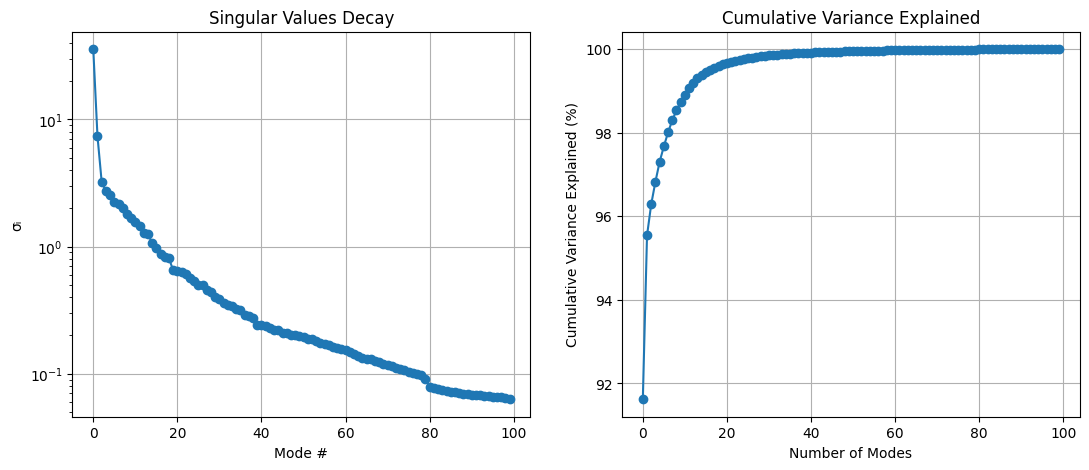

In [5]:
#@title Perform PCA on stacked velocity components [u | v]
# Marco
# 2. Perform PCA on stacked velocity components [u | v]
# Assumes: u_total, v_total, xx, yy already exist from the visualisation cell.
print("Performing PCA (POD) on vector field via SVD...")

import numpy as np
import matplotlib.pyplot as plt

nT = u_total.shape[0]
nxy = xx.size

# Build data matrix: each row = snapshot; columns = [u(:), v(:)]
Xu = u_total.reshape(nT, nxy)
Xv = v_total.reshape(nT, nxy)
X_uv = np.hstack([Xu, Xv])          # shape (nT, 2*nxy)

# Center in time (do NOT standardize for POD)
X_mean = X_uv.mean(axis=0, keepdims=True)
X_centered = X_uv - X_mean

# SVD
U, S, VT = np.linalg.svd(X_centered, full_matrices=False)

# 3. Visualise singular value decay and cumulative variance explained
kmax = min(100, S.size)
explained = (S**2) / np.sum(S**2)
cum_expl = np.cumsum(explained)

plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.semilogy(S[:kmax], marker='o')
plt.title('Singular Values Decay')
plt.xlabel('Mode #')
plt.ylabel('σᵢ')
plt.grid(visible=True)

plt.subplot(1, 2, 2)
plt.plot(100 * cum_expl[:kmax], marker='o')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Variance Explained (%)')
plt.grid(visible=True)

plt.show()

# Helper to extract vector spatial modes later (optional, handy for plotting):
# i-th right singular vector splits into u- and v-parts
def mode_uv(i):
    vec = VT[i]
    u_mode = vec[:nxy].reshape(yy.shape)
    v_mode = vec[nxy:].reshape(yy.shape)
    return u_mode, v_mode


Visualising first 3 spatial modes (u and v separately)...


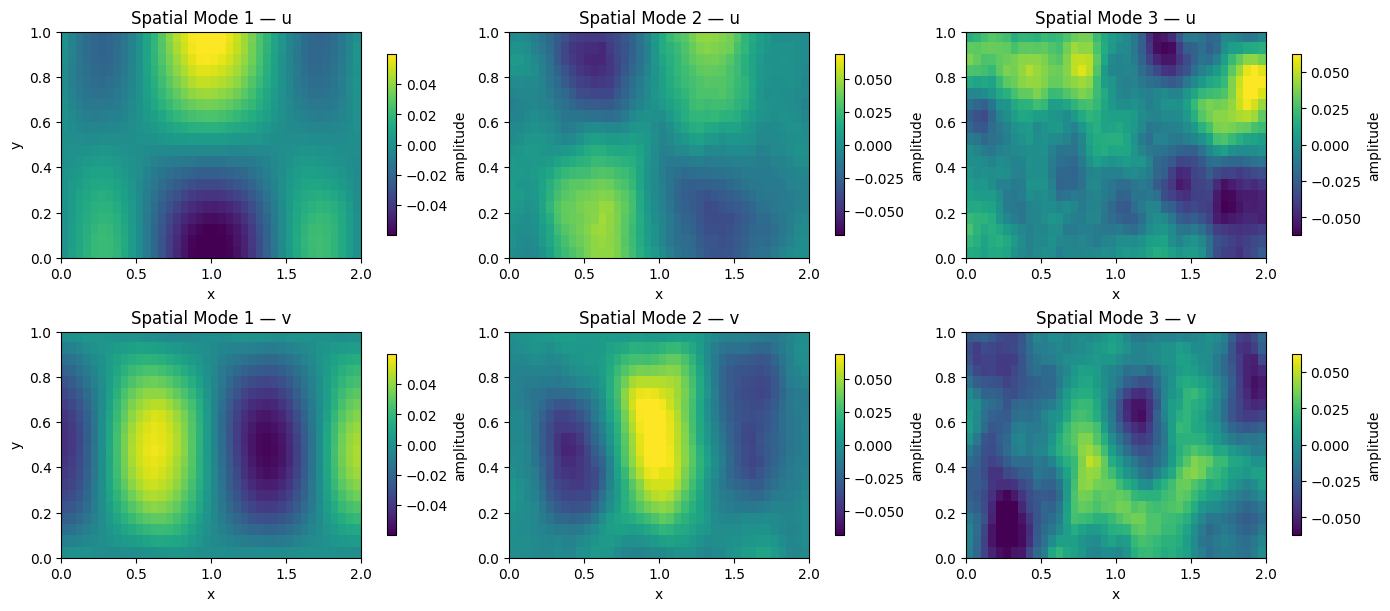

Visualising the first 3 temporal modes (shared for u & v)...


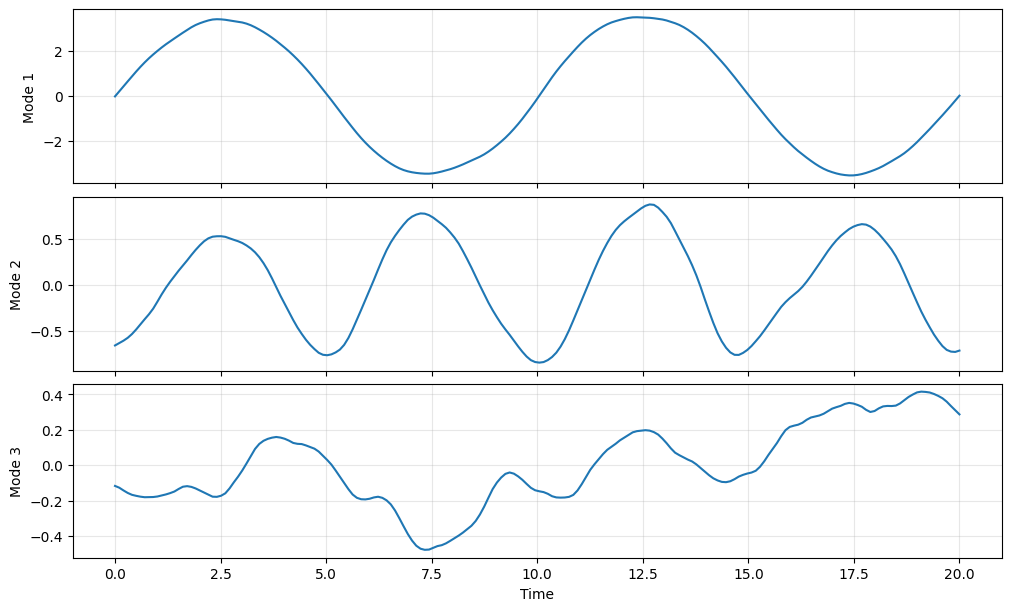

In [6]:
#@title Visualise first 3 spatial and temporal modes
# Marco
# 4. Visualise first 3 spatial modes (u and v shown separately)
print("Visualising first 3 spatial modes (u and v separately)...")

import numpy as np
import matplotlib.pyplot as plt

modes_to_show = 3
nxy = xx.size

fig, axes = plt.subplots(2, modes_to_show, figsize=(4.6*modes_to_show, 6), constrained_layout=True)

for i in range(modes_to_show):
    # split the i-th right singular vector into u- and v-parts
    u_mode = VT[i, :nxy].reshape(yy.shape)
    v_mode = VT[i, nxy:].reshape(yy.shape)

    # common symmetric color scale for u & v of this mode
    lim = np.nanpercentile(np.abs(np.r_[u_mode.ravel(), v_mode.ravel()]), 99)
    vmin, vmax = -lim, lim

    im_u = axes[0, i].imshow(u_mode, origin='lower',
                             extent=[xx.min(), xx.max(), yy.min(), yy.max()],
                             vmin=vmin, vmax=vmax, aspect='auto')
    axes[0, i].set_title(f"Spatial Mode {i+1} — u")
    if i == 0: axes[0, i].set_ylabel("y")
    axes[0, i].set_xlabel("x")
    cbu = fig.colorbar(im_u, ax=axes[0, i], shrink=0.8)
    cbu.set_label("amplitude")

    im_v = axes[1, i].imshow(v_mode, origin='lower',
                             extent=[xx.min(), xx.max(), yy.min(), yy.max()],
                             vmin=vmin, vmax=vmax, aspect='auto')
    axes[1, i].set_title(f"Spatial Mode {i+1} — v")
    if i == 0: axes[1, i].set_ylabel("y")
    axes[1, i].set_xlabel("x")
    cbv = fig.colorbar(im_v, ax=axes[1, i], shrink=0.8)
    cbv.set_label("amplitude")

plt.show()

# 5. Visualise the first 3 temporal modes (shared by u & v)
print("Visualising the first 3 temporal modes (shared for u & v)...")

# Use real time axis if available; otherwise use index
t_axis = t_space if 't_space' in locals() else np.arange(U.shape[0])

fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True, constrained_layout=True)
for i in range(modes_to_show):
    axs[i].plot(t_axis, U[:, i] * S[i])
    axs[i].set_ylabel(f"Mode {i+1}")
    axs[i].grid(True, alpha=0.3)

axs[-1].set_xlabel("Time" if 't_space' in locals() else "Time index")
plt.show()


In [7]:
n_modes_to_reconstruct = 2

In [8]:
# @title Reconstruct Data (vector-field PCA on stacked [u | v])
# Marco
# 6. Reconstruct Data (vector-field PCA on stacked [u | v])
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# ---- choose how many modes to keep ----
# n_modes_to_reconstruct = 10   # <- adjust as you like
print(f"Reconstructing flow using {n_modes_to_reconstruct} mode(s)...")

# Reconstruct stacked field: shape (nT, 2*nxy)
X_reconstructed = (U[:, :n_modes_to_reconstruct] * S[:n_modes_to_reconstruct]) @ VT[:n_modes_to_reconstruct, :] + X_mean

# Report cumulative variance explained (fixing the format bug)
cum = np.cumsum(S**2) / np.sum(S**2)
pct = 100.0 * cum[n_modes_to_reconstruct - 1]
print(f"Cumulative variance explained by first {n_modes_to_reconstruct} mode(s): {pct:.2f}%")

# Split into components and reshape back to (nT, ny, nx)
nT = U.shape[0]
ny, nx = yy.shape
nxy = nx * ny
u_rec = X_reconstructed[:, :nxy].reshape(nT, ny, nx)
v_rec = X_reconstructed[:, nxy:].reshape(nT, ny, nx)

# ---- Helper: animate u & v components side-by-side (fast, no streamlines) ----
def animate_uv_components(u_arr, v_arr, xx, yy, title="", N_FRAMES=40, INTERVAL_MS=60, DECIM=1, vmin=None, vmax=None):
    # Shared symmetric color scale (prefer from true data if available)
    if vmin is None or vmax is None:
        if 'u_total' in locals() and 'v_total' in locals():
            abs99 = np.nanpercentile(np.abs(np.r_[u_total.ravel(), v_total.ravel()]), 99)
        else:
            abs99 = np.nanpercentile(np.abs(np.r_[u_arr.ravel(), v_arr.ravel()]), 99)
        vmin, vmax = -abs99, abs99

    nT = u_arr.shape[0]
    frame_idx = np.linspace(0, nT - 1, N_FRAMES, dtype=int)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im_u = axes[0].imshow(u_arr[frame_idx[0]][::DECIM, ::DECIM], origin='lower',
                          extent=[xx.min(), xx.max(), yy.min(), yy.max()],
                          vmin=vmin, vmax=vmax, aspect='auto')
    axes[0].set_title(f"u(x,y,t idx={frame_idx[0]})"); axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
    cbar_u = fig.colorbar(im_u, ax=axes[0], shrink=0.8); cbar_u.set_label("u")

    im_v = axes[1].imshow(v_arr[frame_idx[0]][::DECIM, ::DECIM], origin='lower',
                          extent=[xx.min(), xx.max(), yy.min(), yy.max()],
                          vmin=vmin, vmax=vmax, aspect='auto')
    axes[1].set_title(f"v(x,y,t idx={frame_idx[0]})"); axes[1].set_xlabel("x"); axes[1].set_ylabel("y")
    cbar_v = fig.colorbar(im_v, ax=axes[1], shrink=0.8); cbar_v.set_label("v")

    if title:
        fig.suptitle(title)
    fig.tight_layout()

    def update(fi):
        im_u.set_data(u_arr[fi][::DECIM, ::DECIM])
        im_v.set_data(v_arr[fi][::DECIM, ::DECIM])
        axes[0].set_title(f"u(x,y,t idx={fi})")
        axes[1].set_title(f"v(x,y,t idx={fi})")
        return [im_u, im_v]

    ani = FuncAnimation(fig, update, frames=frame_idx, interval=INTERVAL_MS, blit=False)
    plt.close(fig)
    return ani

## ---- Make the animation for reconstructed u & v ----
#ani_reconstructed_uv = animate_uv_components(
#    u_rec, v_rec, xx, yy,
#    title=f"Reconstructed Components (r={n_modes_to_reconstruct})",
#    N_FRAMES=40, INTERVAL_MS=60, DECIM=1
#)
#
#print(f"\n--- Reconstructed Components Animation (r={n_modes_to_reconstruct}) ---")
#display(HTML(ani_reconstructed_uv.to_html5_video()))

# --- SINGLE synchronized comparison video: reconstructed vs original (u & v) ---
# Requires: u_rec, v_rec   (from your reconstruction cell)
#           u_total, v_total, xx, yy, n_modes_to_reconstruct

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Settings (tweak for speed/size)
N_FRAMES = 40
INTERVAL_MS = 60
DECIM = 1   # increase to 2–4 to decimate grid and speed up rendering

# Choose evenly spaced time indices across the series
nT = u_rec.shape[0]
frame_idx = np.linspace(0, nT - 1, N_FRAMES, dtype=int)

# Shared color scale per component (u has its own, v has its own), across rec+orig
abs99_u = np.nanpercentile(np.abs(np.r_[u_rec.ravel(), u_total.ravel()]), 99)
abs99_v = np.nanpercentile(np.abs(np.r_[v_rec.ravel(), v_total.ravel()]), 99)
vmin_u, vmax_u = -abs99_u, abs99_u
vmin_v, vmax_v = -abs99_v, abs99_v

# Decimated coordinate extents (imshow uses extents; we can keep original)
extent = [xx.min(), xx.max(), yy.min(), yy.max()]

fig, axes = plt.subplots(2, 2, figsize=(11, 8))
fig.suptitle(f"Vector-PCA reconstruction (r={n_modes_to_reconstruct}) — synchronized comparison", y=0.98)

# First frame
i0 = frame_idx[0]
im_rec_u = axes[0,0].imshow(u_rec[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_u, vmax=vmax_u, aspect='auto')
axes[0,0].set_title("Reconstructed u"); axes[0,0].set_xlabel("x"); axes[0,0].set_ylabel("y")
fig.colorbar(im_rec_u, ax=axes[0,0], shrink=0.8, label="u")

im_rec_v = axes[0,1].imshow(v_rec[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_v, vmax=vmax_v, aspect='auto')
axes[0,1].set_title("Reconstructed v"); axes[0,1].set_xlabel("x"); axes[0,1].set_ylabel("y")
fig.colorbar(im_rec_v, ax=axes[0,1], shrink=0.8, label="v")

im_org_u = axes[1,0].imshow(u_total[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_u, vmax=vmax_u, aspect='auto')
axes[1,0].set_title("Original u"); axes[1,0].set_xlabel("x"); axes[1,0].set_ylabel("y")
fig.colorbar(im_org_u, ax=axes[1,0], shrink=0.8, label="u")

im_org_v = axes[1,1].imshow(v_total[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_v, vmax=vmax_v, aspect='auto')
axes[1,1].set_title("Original v"); axes[1,1].set_xlabel("x"); axes[1,1].set_ylabel("y")
fig.colorbar(im_org_v, ax=axes[1,1], shrink=0.8, label="v")

plt.tight_layout()

def update(fi):
    im_rec_u.set_data(u_rec[fi][::DECIM, ::DECIM])
    im_rec_v.set_data(v_rec[fi][::DECIM, ::DECIM])
    im_org_u.set_data(u_total[fi][::DECIM, ::DECIM])
    im_org_v.set_data(v_total[fi][::DECIM, ::DECIM])
    axes[0,0].set_title(f"Reconstructed u (t idx={fi})")
    axes[0,1].set_title(f"Reconstructed v (t idx={fi})")
    axes[1,0].set_title(f"Original u (t idx={fi})")
    axes[1,1].set_title(f"Original v (t idx={fi})")
    return [im_rec_u, im_rec_v, im_org_u, im_org_v]

ani_compare = FuncAnimation(fig, update, frames=frame_idx, interval=INTERVAL_MS, blit=False)
plt.close(fig)

print("\n--- Synchronized Reconstruction vs Original (u & v) ---")
display(HTML(ani_compare.to_html5_video()))


Reconstructing flow using 2 mode(s)...
Cumulative variance explained by first 2 mode(s): 95.54%

--- Synchronized Reconstruction vs Original (u & v) ---


# Sparse PCA: purpose, differences from PCA

## What it is
Sparse PCA (SPCA) is a low-rank factorization that finds components (loadings) which are **sparse** across sensors (features). The goal is the same spirit as PCA "compress and reveal structure" but with **localized, interpretable modes** rather than dense ones.

Typical uses:
- Interpretability: highlight **where** variability lives (support maps).
- Sensor selection and placement: identify a **small subset of sensors** that explain most variation.
- Region-of-interest analysis and feature selection in high-dimensional data.

## Key differences vs standard PCA
- **PCA** has a closed-form SVD on centered data. Modes are **dense**, **orthogonal**, and **variance-ordered**; the squared singular values equal explained variance.
- **SPCA** solves an **optimization with sparsity penalties**, not an SVD. Components are **sparse**, generally **not orthogonal**, and **not variance-ordered**. Explained variance is assessed via reconstruction fit rather than singular values.
- SPCA trades a bit of fidelity for **localization and interpretability**.

## The optimization problem (lightweight)
With centered data matrix \(X \in \mathbb{R}^{T \times F}\), SPCA approximates
$
X \approx C W,
$
by solving
$
\min_{C,\,W}\ \tfrac{1}{2}\,\lVert X - C W \rVert_F^2 \;+\; \alpha\,\lVert W \rVert_1 \;+\; \tfrac{\beta}{2}\,\lVert W \rVert_F^2
\quad \text{s.t.} \quad \lVert C_{:j} \rVert_2 \le 1 \ \forall j,
$
where:
- $W \in \mathbb{R}^{r \times F}$ are the **sparse loadings** (spatial components);
- $C \in \mathbb{R}^{T \times r}$ are the **codes** (temporal activations);
- $\alpha$ controls sparsity (larger \(\alpha\) means more zeros);
- $\beta$ is a small ridge term (numerical stability).

The problem is solved iteratively (alternating minimization with Lasso-type steps). There is no single SVD step.

## Why standardization and why scale matters
The sparsity penalty $\lVert W \rVert_1$ acts **per feature**. If features have different scales, large-variance features are **implicitly cheaper** to keep nonzero, and small-variance ones are over-penalized. Therefore we:
- **Standardize features** (mean 0, variance 1) **before** SPCA;
- Fit SPCA in standardized space;
- **Map components and reconstructions back** to original physical units using the inverse transform when we visualize or compare to PCA.

Without standardization, sparsity patterns largely reflect **units** rather than **structure**.

## Disadvantages vs PCA
- No orthogonality or variance ordering; components can be **correlated** and their scale/sign are arbitrary.
- **No closed form**; requires **hyperparameters** ($\alpha$, $\beta$, $r$) and may converge to **local minima**. Slower than PCA.
- Explained variance is **not** read from singular values; reconstruction fit is typically **worse** than PCA for the same number of components.
- Results depend on **standardization choices** and can be less stable across runs or slight data changes.

## When to pick SPCA
Choose SPCA when **where** matters more than squeezing out the last bit of variance: you want localized, interpretable patterns or a small set of informative sensors. Use PCA when you want the **best energy capture** and orthogonal modes for compression and low-rank modeling.




In [9]:
#@title Compute SPCA on stacked [u | v]
# MARCO
# === Sparse PCA on stacked [u | v] ===
import numpy as np
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

print("Preparing stacked [u|v] data for Sparse PCA...")

# Build X_uv if not already available (rows = snapshots, cols = [u(:), v(:)])
if 'X_uv' not in locals():
    nT = u_total.shape[0]
    nxy = xx.size
    Xu = u_total.reshape(nT, nxy)
    Xv = v_total.reshape(nT, nxy)
    X_uv = np.hstack([Xu, Xv])  # shape (T, 2*nxy)

# 1) Standardize features (mean 0, var 1) — important for SparsePCA
print("Standardizing the stacked components (mean=0, variance=1)...")
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_uv)

# 2) Define Sparse PCA parameters
n_sparse_modes = 3
alpha_regularization = 1.0  # tune: larger -> sparser components
print(f"Applying SparsePCA on standardized [u|v] (n_components={n_sparse_modes}, alpha={alpha_regularization})...")

# 3) Fit SparsePCA
spca = SparsePCA(
    n_components=n_sparse_modes,
    alpha=alpha_regularization,
    random_state=0,
    n_jobs=-1
)
codes = spca.fit_transform(X_scaled)    # shape (T, n_sparse_modes)
components_std = spca.components_       # shape (n_sparse_modes, 2*nxy), in standardized feature coords
print("Sparse PCA computed.")

# --- Quick sanity checks / utilities ---

# Reconstruction (standardized space -> back to original units)
X_scaled_hat = codes @ components_std
X_spca = scaler.inverse_transform(X_scaled_hat)  # same shape as X_uv

# Map sparse components to original feature units (useful for plotting u/v parts)
scale_vec = scaler.scale_  # per-feature std used by the scaler
components_orig = components_std * scale_vec  # broadcast multiply, shape (n_sparse_modes, 2*nxy)

def spca_mode_uv(j):
    """Return (u_mode, v_mode) of sparse component j in ORIGINAL units."""
    u_mode = components_orig[j, :nxy].reshape(yy.shape)
    v_mode = components_orig[j, nxy:].reshape(yy.shape)
    return u_mode, v_mode

# Approx. variance captured by the SparsePCA subspace (on standardized data)
tot = np.sum(X_scaled**2)
resid = np.sum((X_scaled - X_scaled_hat)**2)
r2 = 1.0 - resid / tot
print(f"Approx. variance captured by SparsePCA subspace: {100*r2:.2f}%")

# Optional: alignment of SparsePCA components with top PCA modes (cosine similarity)
# Uses PCA right singular vectors VT (rows = PCA modes) in original units.
if 'VT' in locals():
    V = VT  # shape (r, 2*nxy)
    comps_norm = components_orig / np.linalg.norm(components_orig, axis=1, keepdims=True)
    # Compare to the first 6 PCA modes (adjust as you like)
    k_compare = min(6, V.shape[0])
    cos = np.abs(comps_norm @ V[:k_compare].T)  # (n_sparse_modes x k_compare)
    print("Cosine similarity of SparsePCA components vs top PCA modes (rows = sparse comps):")
    print(np.round(cos, 3))


Preparing stacked [u|v] data for Sparse PCA...
Standardizing the stacked components (mean=0, variance=1)...
Applying SparsePCA on standardized [u|v] (n_components=3, alpha=1.0)...
Sparse PCA computed.
Approx. variance captured by SparsePCA subspace: 78.67%
Cosine similarity of SparsePCA components vs top PCA modes (rows = sparse comps):
[[1.    0.018 0.011 0.001 0.001 0.004]
 [0.069 0.962 0.079 0.058 0.039 0.036]
 [0.101 0.246 0.806 0.017 0.065 0.222]]


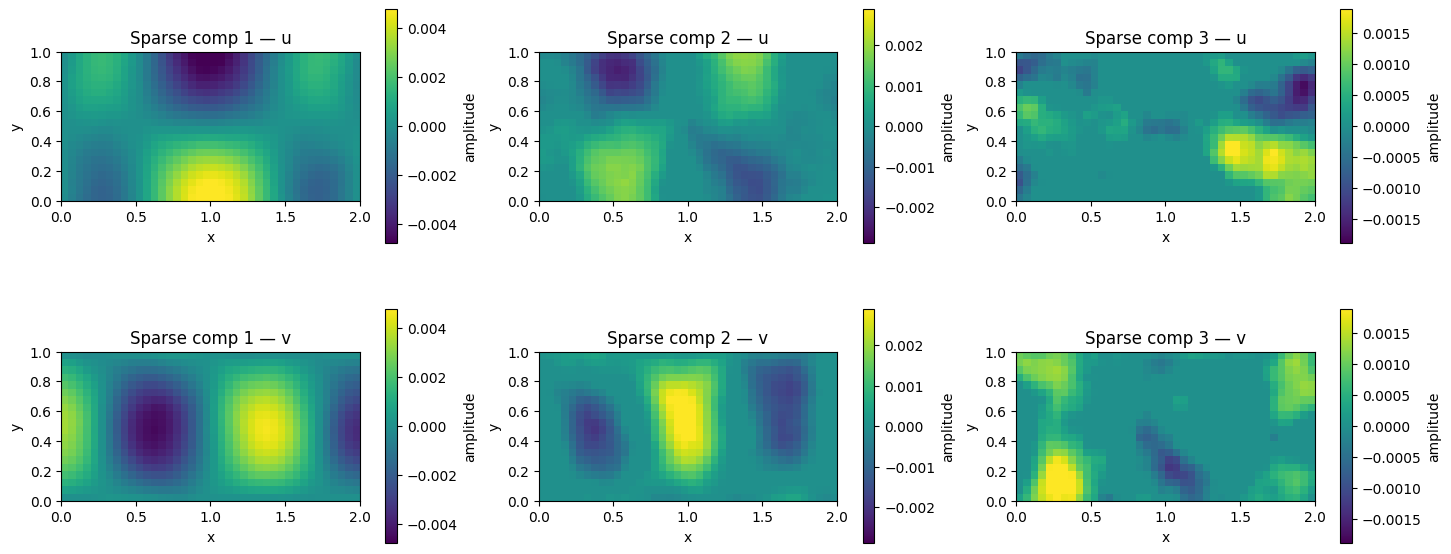

Sparse component 1: nonzeros u = 778/800 (97.25%), v = 767/800 (95.88%)
Sparse component 2: nonzeros u = 616/800 (77.00%), v = 546/800 (68.25%)
Sparse component 3: nonzeros u = 403/800 (50.38%), v = 408/800 (51.00%)


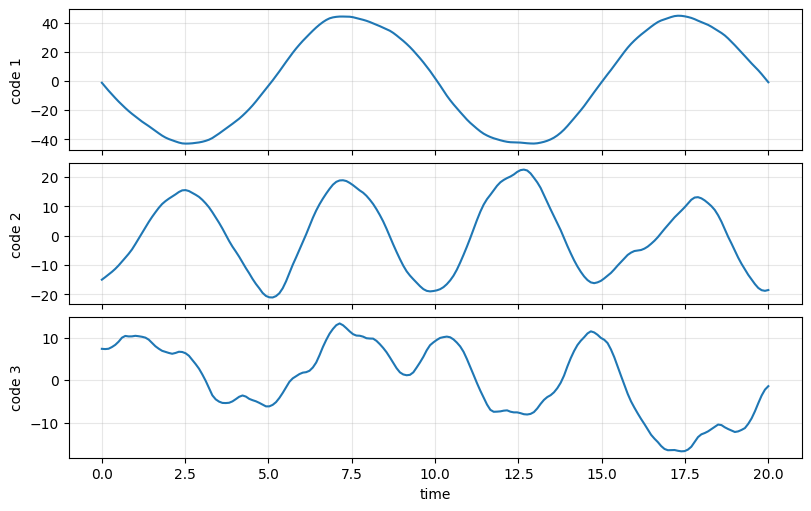

In [12]:
# @title Visualize first 3 SparsePCA spatial modes per velocity component
# MARCO
# === Visualize first 3 SparsePCA spatial modes per component (u on top, v below) ===
import numpy as np
import matplotlib.pyplot as plt

modes_to_show = min(3, components_orig.shape[0])
nxy = xx.size
extent = [xx.min(), xx.max(), yy.min(), yy.max()]

fig, axes = plt.subplots(2, modes_to_show, figsize=(4.8*modes_to_show, 6), constrained_layout=True)

sparsity_report = []
for j in range(modes_to_show):
    # Get u/v parts in ORIGINAL units
    u_mode, v_mode = spca_mode_uv(j)

    # Symmetric color scale per component (shared between its u and v)
    lim = np.nanpercentile(np.abs(np.r_[u_mode.ravel(), v_mode.ravel()]), 99)
    vmin, vmax = -lim, lim

    # Plot u
    im_u = axes[0, j].imshow(
        u_mode, origin="lower", extent=extent, vmin=vmin, vmax=vmax, aspect="equal"
    )
    axes[0, j].set_title(f"Sparse comp {j+1} — u")
    axes[0, j].set_xlabel("x"); axes[0, j].set_ylabel("y")
    cb_u = fig.colorbar(im_u, ax=axes[0, j], shrink=0.8)
    cb_u.set_label("amplitude")

    # Plot v
    im_v = axes[1, j].imshow(
        v_mode, origin="lower", extent=extent, vmin=vmin, vmax=vmax, aspect="equal"
    )
    axes[1, j].set_title(f"Sparse comp {j+1} — v")
    axes[1, j].set_xlabel("x"); axes[1, j].set_ylabel("y")
    cb_v = fig.colorbar(im_v, ax=axes[1, j], shrink=0.8)
    cb_v.set_label("amplitude")

    # Sparsity stats (using a small threshold to ignore numerical dust)
    thr = 1e-8 * max(1.0, np.max(np.abs(components_orig[j])))
    nz_u = np.count_nonzero(np.abs(components_orig[j, :nxy]) > thr)
    nz_v = np.count_nonzero(np.abs(components_orig[j, nxy:]) > thr)
    sparsity_report.append((j+1, nz_u, nz_v))

# lock aspect and limits
for ax in axes.ravel():
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

plt.show()

# Optional: print a compact sparsity summary
total_u = nxy
total_v = nxy
for j, nz_u, nz_v in sparsity_report:
    pu = 100.0 * nz_u / total_u
    pv = 100.0 * nz_v / total_v
    print(f"Sparse component {j}: nonzeros u = {nz_u}/{total_u} ({pu:.2f}%), v = {nz_v}/{total_v} ({pv:.2f}%)")

# Optional (temporal activations): plot the first 3 sparse codes to connect to PCA time modes
fig, axs = plt.subplots(modes_to_show, 1, figsize=(8, 5), sharex=True, constrained_layout=True)
t_axis = np.arange(codes.shape[0]) if "t_space" not in locals() else t_space
for j in range(modes_to_show):
    axs[j].plot(t_axis, codes[:, j])
    axs[j].set_ylabel(f"code {j+1}")
    axs[j].grid(True, alpha=0.3)
axs[-1].set_xlabel("time")
plt.show()


### How to read your SparsePCA plots

- Zeros = “inactive sensors.” After standardizing features, the L1-like penalty drives many coefficients to 0. Non-zero patches show where each component lives on the grid.

- Comp 1 looks like PCA mode 1 (global gyre sway) but with small/flat regions zeroed out.

- Comp 2 captures the next coherent pattern (the left/right lobe contrast) and is much sparser—it drops background regions that don’t help distinguish that pattern.

- Comp 3 is mostly small-scale/patchy: it’s isolating parts of the perturbation field your PCA mode 3 also hinted at. Its sparsity tells you those fluctuations are spatially localized.

In [11]:
#@title SparsePCA reconstruction and comparison
# MARCO
# === SparsePCA reconstruction and synchronized comparison video ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

print("Reconstructing data from SparsePCA components...")

# Safety: if you have not kept these names from the SPCA fit cell, adapt them here:
# - scaler          : fitted StandardScaler on X_uv
# - spca            : fitted SparsePCA model
# - codes           : spca.fit_transform(X_scaled), shape (T, n_sparse_modes)
# - components_std  : spca.components_, shape (n_sparse_modes, 2*nxy)
# - X_uv            : original stacked data (T, 2*nxy) in physical units
# - u_total, v_total, xx, yy

# 1) Reconstruct in standardized space, then invert scaling back to physical units
X_scaled_hat = codes @ components_std                            # standardized coords
X_spca_hat   = scaler.inverse_transform(X_scaled_hat)            # back to original units

# 2) Split into components and reshape
nT = X_spca_hat.shape[0]
ny, nx = yy.shape
nxy = nx * ny
u_rec_spca = X_spca_hat[:, :nxy].reshape(nT, ny, nx)
v_rec_spca = X_spca_hat[:, nxy:].reshape(nT, ny, nx)

print("Reconstruction complete.")

# 3) Explained variance style metrics
#    Note: SparsePCA components are not orthogonal, so we report an R^2 computed on standardized data.
X_scaled = scaler.transform(X_uv)                                # standardized original data
num = np.sum((X_scaled - X_scaled_hat)**2)
den = np.sum(X_scaled**2)
r2_std = 1.0 - num/den
print(f"Approx. explained variance in standardized space (R^2): {100.0*r2_std:.2f}%")

# Also report relative Frobenius error in original units (purely for reference)
rel_err_orig = np.linalg.norm(X_uv - X_spca_hat, ord='fro') / np.linalg.norm(X_uv, ord='fro')
print(f"Relative Frobenius error in original units: {100.0*rel_err_orig:.2f}%  (lower is better)")

# 4) Single synchronized comparison video: top = SPCA recon (u,v), bottom = original (u,v)
N_FRAMES = 40
INTERVAL_MS = 60
DECIM = 1  # increase to 2..4 to speed up

frame_idx = np.linspace(0, nT - 1, N_FRAMES, dtype=int)

# Component-wise color scales shared between recon and original
abs99_u = np.nanpercentile(np.r_[u_rec_spca.ravel(), u_total.ravel()], 99)
abs99_v = np.nanpercentile(np.r_[v_rec_spca.ravel(), v_total.ravel()], 99)
vmin_u, vmax_u = -abs99_u, abs99_u
vmin_v, vmax_v = -abs99_v, abs99_v

extent = [xx.min(), xx.max(), yy.min(), yy.max()]

fig, axes = plt.subplots(2, 2, figsize=(11, 8))
fig.suptitle(f"SparsePCA reconstruction (r={spca.n_components}) vs original", y=0.98)

i0 = frame_idx[0]
# Row 1: SPCA reconstruction
im_rec_u = axes[0,0].imshow(u_rec_spca[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_u, vmax=vmax_u, aspect='equal')
axes[0,0].set_title("Reconstructed u"); axes[0,0].set_xlabel("x"); axes[0,0].set_ylabel("y")
fig.colorbar(im_rec_u, ax=axes[0,0], shrink=0.8, label="u")

im_rec_v = axes[0,1].imshow(v_rec_spca[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_v, vmax=vmax_v, aspect='equal')
axes[0,1].set_title("Reconstructed v"); axes[0,1].set_xlabel("x"); axes[0,1].set_ylabel("y")
fig.colorbar(im_rec_v, ax=axes[0,1], shrink=0.8, label="v")

# Row 2: Original
im_org_u = axes[1,0].imshow(u_total[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_u, vmax=vmax_u, aspect='equal')
axes[1,0].set_title("Original u"); axes[1,0].set_xlabel("x"); axes[1,0].set_ylabel("y")
fig.colorbar(im_org_u, ax=axes[1,0], shrink=0.8, label="u")

im_org_v = axes[1,1].imshow(v_total[i0][::DECIM, ::DECIM], origin='lower', extent=extent,
                            vmin=vmin_v, vmax=vmax_v, aspect='equal')
axes[1,1].set_title("Original v"); axes[1,1].set_xlabel("x"); axes[1,1].set_ylabel("y")
fig.colorbar(im_org_v, ax=axes[1,1], shrink=0.8, label="v")

# lock aspect and limits
for ax in axes.ravel():
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

plt.tight_layout()

def update(fi):
    im_rec_u.set_data(u_rec_spca[fi][::DECIM, ::DECIM])
    im_rec_v.set_data(v_rec_spca[fi][::DECIM, ::DECIM])
    im_org_u.set_data(u_total[fi][::DECIM, ::DECIM])
    im_org_v.set_data(v_total[fi][::DECIM, ::DECIM])
    axes[0,0].set_title(f"Reconstructed u (t idx={fi})")
    axes[0,1].set_title(f"Reconstructed v (t idx={fi})")
    axes[1,0].set_title(f"Original u (t idx={fi})")
    axes[1,1].set_title(f"Original v (t idx={fi})")
    return [im_rec_u, im_rec_v, im_org_u, im_org_v]

ani_spca_compare = FuncAnimation(fig, update, frames=frame_idx, interval=INTERVAL_MS, blit=False)
plt.close(fig)

print("\n--- SparsePCA reconstruction vs original (synchronized) ---")
display(HTML(ani_spca_compare.to_html5_video()))


Reconstructing data from SparsePCA components...
Reconstruction complete.
Approx. explained variance in standardized space (R^2): 78.67%
Relative Frobenius error in original units: 8.54%  (lower is better)

--- SparsePCA reconstruction vs original (synchronized) ---


## Classification / clustering
When no labels guide us, clustering becomes our lens for discovering latent groupings—“natural categories” that emerge purely from the geometry of the data cloud.  Formally we are looking for a partition of the point set $\{\mathbf{x}_i\}_{i=1}^N\subset\mathbb{R}^p$ that makes members of the same cluster more similar to one another than to points outside.  Yet similarity is in the eye of the algorithm.  **$k$-means** measures it with global Euclidean distance from movable centroids and therefore prefers compact, roughly spherical groups; **hierarchical linkage** builds a full dendrogram by agglomerating the closest pairs, exposing structure at every scale but forcing the analyst to decide where to “cut” the tree; **spectral clustering** turns the data into a nearest‑neighbour graph and seeks a low‑conductance cut, capturing connectivity rather than simple distance.  We will illustrate these biases with a deliberately eclectic 2‑D toy set that combines tight Gaussian blobs, an elongated cigar, a curved crescent and a sprinkling of stray points.  Watching each method succeed on some shapes and stumble on others makes vivid the central lesson: clustering is not a one‑size‑fits‑all tool but a family of algorithms whose output reflects the particular notion of proximity they encode.


In [ ]:
#@title Data generation and k-means clustering code -- run this cell to generate the data, no need to look at the code

def k_means_step(X, centroids):
    """
    Inputs:
    X : (N_samples, N_features) matrix
        Data to cluster.
    centroids : (n_clusters, N_features) matrix
    """

    n_clusters = centroids.shape[0]

    # check connectivity of centroids
    labels = np.zeros(X.shape[0], dtype=int)
    d = np.zeros((n_clusters))
    for i in range(X.shape[0]):
        for k in range(n_clusters):
            d[k] = np.linalg.norm(X[i,:] - centroids[k,:])
        labels[i] = np.argmin(d)  # assign to the closest centroid


    new_centroids = np.zeros(centroids.shape)
    for k in range(centroids.shape[0]):
        new_centroids[k,:] = np.mean(X[labels == k, :], axis=0)
    return labels, new_centroids

def k_means(X, n_clusters=3, max_iter=100, n_inits=10):
    """
    K-means clustering algorithm.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    n_clusters : int
        Number of clusters.
    max_iter : int
        Maximum number of iterations.
    n_inits : int
        Number of times the algorithm will be run with different centroid seeds.

    Returns
    -------
    labels : (N_samples,) array-like
        Cluster labels for each sample.
    centroids : (n_clusters, N_features) array-like
        Final cluster centroids.
    """
    # Initialize random centroids
    loss = np.inf
    for k in range(n_inits):
        np.random.seed(k)
        initial_indices = np.random.choice(X.shape[0], n_clusters, replace=False)
        centroids = X[initial_indices, :]

        for _ in range(max_iter):
            labels, new_centroids = k_means_step(X, centroids)
            if np.all(centroids == new_centroids):
                break  # Convergence
            centroids = new_centroids

        loss_new = np.sum((X - centroids[labels])**2)
        if loss_new < loss:
            loss = loss_new
            best_labels = labels
            best_centroids = centroids

    return best_labels, best_centroids


def animated_kmeans_process(X, centroids, n_frames=4, interval=100):
    """
    Animated k-means clustering process.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    n_clusters : int
        Number of clusters.
    n_frames : int
        Number of frames in the animation.
    interval : int
        Delay between frames in milliseconds.
    """
    # # Initialize random centroids
    # np.random.seed(1)
    # initial_indices = np.random.choice(X.shape[0], n_clusters, replace=False)
    # centroids = X[initial_indices, :]

    # get the labels for initial centroids
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        d1 = np.linalg.norm(X[i,:] - centroids[0,:])
        d2 = np.linalg.norm(X[i,:] - centroids[1,:])
        d3 = np.linalg.norm(X[i,:] - centroids[2,:])
        if d1 < d2 and d1 < d3:
            labels[i] = 0
        elif d2 < d1 and d2 < d3:
            labels[i] = 1
        else:
            labels[i] = 2


    # Prepare the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    scat = ax.scatter(X[:, 0], X[:, 1], c='lightgray', s=10)
    scat.set_array(labels)  # Initial colors based on labels
    centroid_scat = ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')
    ax.set_title("K-means Clustering Process")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    # fig.show()

    def update(frame):
        nonlocal centroids
        nonlocal labels

        scat.set_array(labels)  # Update scatter plot colors based on labels
        centroid_scat.set_offsets(centroids)  # Update centroid positions

        labels, new_centroids = k_means_step(X, centroids)
        centroids = new_centroids
        return scat, centroid_scat

    ani = FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True)
    plt.close(fig)  # Prevent static output in Jupyter Notebook
    return HTML(ani.to_jshtml())


# import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler

# Function to generate toy 2D clusters
def toy_2D_clusters(rng=0):
    rng = np.random.RandomState(rng)

    # A: two tight blobs
    blob_A, _ = make_blobs(n_samples=150, centers=[(-7, 4), (-3, 5)],
                           cluster_std=0.4, random_state=rng)
    # B: elongated Gaussian
    cov = np.array([[4, 0.0], [0.0, 0.1]])
    blob_B = rng.multivariate_normal(mean=[0, 0], cov=cov, size=120)

    # C: half‑moon
    moon, _ = make_moons(n_samples=180, noise=0.05, random_state=rng)
    moon *= 4; moon += [6, -1]

    # D: stray noise
    noise = rng.uniform(low=[-10, -3], high=[8, 3], size=(150, 2))

    X = np.vstack([blob_A, blob_B, moon, noise])
    return StandardScaler().fit_transform(X)  # scale for fair distance use

# Generate data and visualize it
X_all = toy_2D_clusters(rng=1827)  # Generate toy clusters
datasets = ["blobs", "elongated Gaussian", "half-moon", "noise"]

plt.figure(figsize=(7, 7))
for k,set in enumerate(datasets):
    plt.scatter(X_all[k * 150:(k+1)*150-1, 0], X_all[k * 150:(k+1)*150-1, 1], s=10, label=set)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.legend()
plt.title("Toy 2D Clusters")
plt.show()

num_dict = {"blobs": 0,
            "elongated": 1,
            "moons": 2,
            "noise": 3}

### K-means
K-means is a very simple idea for classifying data. Suppose the data lives in $\mathbb{R}^d$, if we have $k$ points in $\mathbb{R}^d$, it is natural to classify each point of the wider data set based on which of the $k$ points it is closest to. This then results in $k$ clusters. K-means is the algorithm of iterating this grouping with moving the central points. Simply the algorithm can be described as

1. Generate $k$ random starting points, called $c_j^0$
2. Find the data points $\{X_i^{j,n}\}$ which has $c_j^{n}$ the closest
3. Update the central points to according to $c_j^{n+1} = $ mean($\{X_i^{j,n}\}$)
4. Go to 2, unless $c_j^{n+1} = c_j^n$.

Please watch the animated illustration on a dataset of your choosing. Here we use $k=3$

In [ ]:
# Illustration of k-means clustering
np.random.seed(1827)  # For reproducibility
dataset = "moons" # Choose dataset, "blobs", "elongated", "moons", or "noise"

k  = num_dict[dataset]
X = X_all[k * 150:(k+1)*150-1, :]
cent = np.hstack((np.random.uniform(np.min(X[:,0]), np.max(X[:,0]), size = (3, 1)), np.random.uniform(np.min(X[:,1]), np.max(X[:,1]), size = (3, 1))))
animated_kmeans_process(X, cent, n_frames=10, interval=500)

We call the central points which define the clusters, *centroids*, and the regions of $\mathbb{R}^d$ belonging to each centroid are called *voronoids*. The algorithm described is guaranteed to converge, but because the first step in the algorithm, it is not deterministic. For this reason we must run the algorithm multiple times with different initial centroids, and chose the best results. Usually we quantify the best as being the one minimising $\sum_{i,j} ||{c_j-X_i^j}||$ for the final centroids.

Try different numbers of clusters on all of the datasets

In [ ]:
# K-Means on all datasets
# Chose number of clusters
k = 2  # Change this to select a different number of clusters
dataset = "moons" # Choose dataset, "blobs", "elongated", "moons", or "noise"

kk = num_dict[dataset]
X = X_all[kk * 150:(kk+1)*150-1, :]
labels, centroids = k_means(X, n_clusters=k, max_iter=100, n_inits=10)

for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, label=f'Cluster {i+1}')
plt.legend()
plt.title(f'K-Means Clustering on Dataset {dataset} with {k} Clusters')
plt.show()

An important limitation of k-means is that the centroids will always be convex. This we can see is not necessarily desirable by looking at the result of K-means on dataset 2. If you were to manually cluster this dataset, you would likely say that each of the crescents are their own clusters, but K-means can't give that as a result.

### Hierarchical clustering and Dendrograms
Hierarchical (agglomerative) clustering views a data set as a hierarchy of nested groups. Begin with every point in its own cluster; at each step merge the two clusters that are closest according to a *linkage* criterion. In this lab we will contrast two extremes:

* **Single linkage**

  $d_{\text{single}}(A,B)=\displaystyle\min_{i\in A,\;j\in B}\lVert\mathbf{x}_i-\mathbf{x}_j\rVert$
  Merging is driven by the *nearest* pair of points, so the algorithm is keen to join clusters connected by even a thin “chain” of samples. This tendency reveals elongated or curved structures (our crescent), but it can just as easily let stray points bridge otherwise distinct groups.

* **Ward linkage**

  $d_{\text{Ward}}(A,B)=\dfrac{|A|\,|B|}{|A|+|B|}\,\lVert\bar{\mathbf{x}}_A-\bar{\mathbf{x}}_B\rVert^{2}$
  Here the distance equals the increase in total within‑cluster variance were $A$ and $B$ merged. The rule therefore favours compact, roughly isotropic clusters—behaviour reminiscent of $k$-means—yet it produces an entire hierarchy instead of fixing $k$ in advance.

The sequence of merges is recorded in a **dendrogram**, a binary tree whose leaves are individual samples and whose branch heights mark the linkage distances at which clusters fused. Cutting the dendrogram with a horizontal line at height $h$ yields the partition first produced when inter‑cluster distance exceeded $h$; sliding this cut interactively exposes structure from fine to coarse scales. Single linkage will keep the crescent intact at low cuts but may chain noise into it; Ward will absorb noise into variance‑minimising groups yet cleanly separates the tight Gaussian blobs. Other linkage choices—complete, average, centroid—sit between these two, balancing sensitivity to chaining against a bias for compactness, but today’s exercise with single and Ward already reveals how the linkage metric encodes geometric assumptions that fundamentally shape the resulting clusters.



In [ ]:
#@title Functions for hierarchical clustering and dendrogram plotting -- no need to look at the code, just run the cell
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
def heirarchical_clustering(X, method='ward', n_clusters=None):
    """
    Perform hierarchical clustering on the data X using the specified method.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    method : str
        The linkage method to use. Options are 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'.

    Returns
    -------
    Z : (N_samples-1, 4) ndarray
        The hierarchical clustering encoded as a linkage matrix.
    """
    # Compute the distance matrix
    dist_matrix = pdist(X)
    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method=method)
    return Z

def plot_dendrogram(Z, labels=None, title='Hierarchical Clustering Dendrogram'):
    """
    Plot a dendrogram for the hierarchical clustering.

    Parameters
    ----------
    Z : (N_samples-1, 4) ndarray
        The hierarchical clustering encoded as a linkage matrix.
    labels : list of str, optional
        Labels for the leaves of the dendrogram.
    title : str, optional
        Title of the dendrogram plot.
    """
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=labels, leaf_rotation=90)
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

def plot_clusters(X, Z, n_clusters, title='Clusters'):
    """
    Plot the clusters formed by hierarchical clustering.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    Z : (N_samples-1, 4) ndarray
        The hierarchical clustering encoded as a linkage matrix.
    n_clusters : int
        The number of clusters to form.
    title : str, optional
        Title of the plot.
    """
    from scipy.cluster.hierarchy import fcluster

    labels = fcluster(Z, n_clusters, criterion='maxclust')

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster Label')
    plt.axis('equal')
    plt.show()

In [ ]:
# Example usage of hierarchical clustering and dendrogram plotting
# Choose the dataset and number of clusters
n_clusters = 2  # Change this to select a different number of clusters
dataset = "moons" # Choose dataset, "blobs", "elongated", "moons", or "noise"

kk = num_dict[dataset]
X = X_all[kk * 150:(kk+1)*150-1, :]

# You might adjust the method. Ward doesn't work well for all datasets.
Z = heirarchical_clustering(X, method='ward') # Try both 'ward' and 'single' methods to see the difference
plot_dendrogram(Z, title='Hierarchical Clustering Dendrogram')
plot_clusters(X, Z, n_clusters=n_clusters, title='Clusters from Hierarchical Clustering')


## Anomaly detection
In anomaly detection we flip the usual learning question: instead of modelling *all* the variability in a data set, we first build a notion of what “normal” looks like and then flag samples that fall outside that description. Because true anomalies are typically rare and unlabeled, the task is almost always **unsupervised**. The output is not a class but a **score**—higher means “more unusual”—followed by a threshold that decides whether to raise an alarm. Setting that threshold is part of the problem: too low and the system cries wolf, too high and genuine faults slip through. Practical recipes fix it by an assumed contamination rate (e.g. the highest 2 % of scores) or by cross‑checking against domain limits.

Different algorithms operationalise “unusual” in different ways. Local methods, such as the $k$-nearest‑neighbour distance score, compare each point only to its immediate neighbourhood and are quick to spot sparse outliers in dense clouds. Global boundary methods like the One‑Class SVM enclose the bulk of the data in a flexible surface and mark anything outside as suspect; they cope better when “normal” fills an irregular but connected region. The following sections apply both viewpoints to a synthetic pulsatile‑pressure trace, showing how the choice of score and threshold trades false positives against missed detections.

We begin by generating the data. The raw data will be a time-series of pressure measurements, with faults such as dropouts and spikes injected into the data set and some Gaussian noise. For the classification, the signal will be divided into windows and the four statistical measures will be used to analyse the windows (mean, standard deviation, skewness, kurtosis).

In [ ]:
#@title No need to look at the code below, just run it to intitialize the synthetic pressure signal generator
def pressure_signal(n_pts=4000,
                    fs=200,                       # Hz
                    noise_std=0.05,
                    spike_frac=0.003,
                    dropout_count=4,
                    shift_count=0,
                    rng=None):
    """
    Generate a synthetic pulsatile pressure trace with injected anomalies.

    Returns
    -------
    t      : (n_pts,)   time axis [s]
    p      : (n_pts,)   pressure signal
    is_anom: (n_pts,)   boolean mask, True where an anomaly was injected
    anomaly_type: (n_pts,)   string array, type of anomaly injected at each point
    """
    rng = np.random.default_rng(rng+1)
    t = np.arange(n_pts) / fs

    # --- clean baseline: two harmonics ---------------------------------------
    p = 2*np.sin(2*np.pi*2*t) + 0.5*np.sin(2*np.pi*4*t)
    anomaly_type = np.full(n_pts, "baseline", dtype=object)

    # --- additive Gaussian noise --------------------------------------------
    p *= 1 + noise_std * rng.standard_normal(n_pts)

    is_anom = np.zeros(n_pts, dtype=bool)

    # --- spikes --------------------------------------------------------------
    n_spike = int(spike_frac * n_pts)
    spike_idx = rng.choice(n_pts, n_spike, replace=False)
    p[spike_idx] += rng.uniform(3, 4, size=n_spike) * rng.choice([-1, 1], n_spike)
    is_anom[spike_idx] = True
    anomaly_type[spike_idx] = "spike"


    # --- drop‑outs -----------------------------------------------------------
    for _ in range(dropout_count):
        start = rng.integers(0, n_pts-50)
        length = rng.integers(20, 40)
        p[start:start+length] = 0.0
        is_anom[start:start+length] = True
        anomaly_type[start:start+length] = "dropout"

    # --- slow level shifts ---------------------------------------------------
    for _ in range(shift_count):
        start = rng.integers(0, n_pts-200)
        amp   = rng.uniform(-1.5, 1.5)
        decay = rng.uniform(0.02, 0.05)        # 1/decay ≈ time‑constant [s]
        span  = np.arange(n_pts-start)
        shift = amp * np.exp(-decay * span)
        p[start:] += shift[: n_pts-start]
        is_anom[start:start+150] = True        # mark first 150 pts as anomalous
        anomaly_type[start:start+150] = "shift"

    return t, p, is_anom, anomaly_type


In [ ]:
#@title Run this to generate and visualize the synthetic pressure signal -- no need to look at the code
t, p, is_anom_true,anomaly_type = pressure_signal(fs=200, rng=2020)
plt.plot(t, p)

colrs = ["r", "g", "m", "y"]
k = 0
for kind in np.unique(anomaly_type):
    if kind == "baseline":
        continue
    plt.scatter(t[anomaly_type == kind], p[anomaly_type == kind], s=10, label=f'Injected {kind}', c=colrs[k])
    k += 1

plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.show()


In [ ]:
#@title Run this to get the window features -- no need to look at the code
from scipy.stats import skew, kurtosis

def window_features(p, fs, win_len=0.25, stride=0.125):
    """
    Parameters
    ----------
    p       : 1‑D array
    fs      : sampling frequency
    win_len : seconds, window length
    stride  : seconds, hop length

    Returns
    -------
    X       : (n_win, 4)  feature matrix  [mean, std, skew, kurtosis]
    idx_win : (n_win,)    index of window start in the original signal
    """
    L = int(win_len * fs)
    H = int(stride * fs)
    idx_win = np.arange(0, len(p)-L+1, H)
    feats = []
    for i in idx_win:
        seg = p[i:i+L]
        feats.append([seg.mean(), seg.std(), skew(seg), kurtosis(seg)])
    return np.array(feats), idx_win, stride


X, idx, H = window_features(p, fs=200)

# Plot the features extracted from the windows
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(X[:, 0], label='Mean')
plt.title('Mean of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Mean Pressure')
plt.subplot(2, 2, 2)
plt.plot(X[:, 1], label='Standard Deviation')
plt.title('Standard Deviation of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Std Pressure')
plt.subplot(2, 2, 3)
plt.plot(X[:, 2], label='Skewness')
plt.title('Skewness of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Skewness')
plt.subplot(2, 2, 4)
plt.plot(X[:, 3], label='Kurtosis')
plt.title('Kurtosis of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Kurtosis')
plt.tight_layout()


### $k$-NN for anomaly detection
The $k$-nearest‑neighbour (kNN) anomaly score treats each sample as a probe of **local density**: if you have to travel far to reach your $k$th neighbour, you must be in a sparse part of the space and are therefore a candidate outlier.  Formally, for a point $\mathbf{x}$ let

$$
s_{k}(\mathbf{x})=\frac1k\sum_{j=1}^{k} \lVert\mathbf{x}-\mathbf{x}_{(j)}\rVert ,
$$

where $\mathbf{x}_{(j)}$ is the $j$th nearest neighbour of $\mathbf{x}$ in the training set.  Large $s_{k}$ means low local density; ranking all samples by this score and thresholding the largest few per cent yields the anomaly set.

This use of $k$-NN differs from the *symmetric graphs* we built for spectral clustering.  There, the edge $i\!\rightarrow\!j$ existed **for both directions**; the goal was a balanced, undirected graph for Laplacian cuts.  In anomaly detection the neighbourhood is evaluated **per point only once** and never symmetrised, because we care about *how isolated that point is*, not about maintaining reciprocity.  As a result, a lone outlier may have large distances to its neighbours even though those neighbours (dense, normal points) have small distances between themselves—exactly the asymmetry we need to flag the outlier.  The only hyper‑parameter is $k$; small values make the score sensitive to fine local structure, while larger $k$ smooth over noise at the risk of diluting rare but genuine anomalies.

Once the scores are generated, we need to determine where to put the cut-off. There are many ways of doing this, you could put a hard cap and say that if $s_{k}(x)$ is greater than a specific value it is an anomaly, but this requires good knowledge about the data set in order to choose the threshold, another option is to assume that there are $p$% faults and discard the $p$% of points with the highest scores. The method we will implement here though is to use K-means in order to construct the threshold. Experiment by choosing the value of $k$ and the number of clusters of K-means.

In [ ]:
#@title run this to initialize the k-NN anomaly detection code -- no need to look at the code
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def detect_knn_anomalies(X, k=5, contamination=0.05, metric='euclidean'):
    """
    k‑NN anomaly detection (distance‑based).

    Parameters
    ----------
    X            : (N_samples, N_features) array
    k            : int, number of neighbours
    contamination: float, fraction of samples to flag as anomalies
    metric       : str, distance metric for scikit‑learn

    Returns
    -------
    is_anom      : (N_samples,) bool array, True where sample is anomalous
    scores       : (N_samples,) float array, k‑NN distance score
    cutoff       : float, threshold applied to scores
    """

    # # standardize the data
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    nbrs = NearestNeighbors(n_neighbors=k + 1, metric=metric).fit(X)
    # distances[:, 0] is distance to itself (0) → skip
    distances, _ = nbrs.kneighbors(X, n_neighbors=k + 1, return_distance=True)
    scores = distances[:, 1:].mean(axis=1)     # average distance to k nearest neighbours

    # threshold by percentile
    cutoff = np.percentile(scores, 100 * (1 - contamination))
    is_anom = scores > cutoff
    return is_anom, scores, cutoff


In [ ]:
# Chose k, contamination ratio, and K-means clusters
k = 5  # number of neighbours for k-NN
contamination = 0.1  # fraction of samples to flag as anomalies when using thresholding
k_means_clusters = 3  # number of clusters for K-means
is_anom, scores, cutoff = detect_knn_anomalies(X, k=k, contamination=contamination)

In [ ]:
#@title Visualize the k-NN anomaly detection results -- no need to look at the code
plt.figure(figsize=(6, 3))
plt.plot(scores, '.', label='score')
plt.axhline(cutoff, color='r', linestyle='--', label='threshold')
plt.xlabel('Window index'); plt.ylabel('k‑NN distance score')
plt.title('k‑NN anomaly scores')
plt.legend()

# Plot the anomalies on the original pressure signal
plt.figure(figsize=(12, 6))
plt.plot(t, p, label='Pressure Signal')
legended = False
for i in range(len(is_anom)):
    if is_anom[i]:
        try:
            plt.axvspan(t[idx[i]], t[idx[i]]+H, color='red', alpha=0.3, label='Detected windows' if not legended else "")
        except IndexError:
            plt.axvspan(t[idx[i]], t[-1], color='red', alpha=0.3, label='Detected windows' if not legended else "")
        legended = True
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()

# overlay the true anomalies
for kind in np.unique(anomaly_type):
    if kind == "baseline":
        continue
    plt.scatter(t[anomaly_type == kind], p[anomaly_type == kind], s=10, label=f'Injected {kind}')
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.title('Detected Anomalies when using a percentile threshold')
plt.show()

# Do k-means clustering on the scores

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k_means_clusters, random_state=42)
kmeans.fit(np.reshape(scores,(len(scores), 1)))

# plot the scores and the clusters
plt.figure(figsize=(6, 3))
plt.scatter(np.arange(len(scores)), scores, c=kmeans.labels_, cmap='viridis', s=10, label='k-means clusters')
plt.legend()
plt.show()

# plot the time series and indicate the anomalies
plt.figure(figsize=(12, 6))
plt.plot(t, p, label='Pressure Signal')
legended = False
biggest_cluster = np.argmax(np.bincount(kmeans.labels_))  # find the largest cluster
is_anom = kmeans.labels_ != biggest_cluster
for i in range(len(is_anom)):
    if is_anom[i]:
        try:
            plt.axvspan(t[idx[i]], t[idx[i]]+H, color='red', alpha=0.3, label='Detected windows' if not legended else "")
        except IndexError:
            plt.axvspan(t[idx[i]], t[-1], color='red', alpha=0.3, label='Detected windows' if not legended else "")
        legended = True

# overlay the true anomalies
for kind in np.unique(anomaly_type):
    if kind == "baseline":
        continue
    plt.scatter(t[anomaly_type == kind], p[anomaly_type == kind], s=10, label=f'Injected {kind}')
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.title('Detected Anomalies using k-means clustering on k-NN scores')
plt.show()

print(f"K-means anomalies flagged: {is_anom.sum()} of {len(X)} windows")




## EXTRA MATERIALS BELOW HERE (ONE-CLASS SVM, GRAPH BASED CLUSTERING)

### One-Class Support Vector Machines
The **One‑Class SVM** builds a *global* envelope around the training data by learning a decision function that is positive on “normal” samples and negative elsewhere. In scikit‑learn this is implemented as the ν‑formulation of the support‑vector machine: given only the uncontaminated portion of the data, the algorithm maps each point into a high‑dimensional feature space (by default with an RBF kernel) and then finds the hyper‑plane that maximises its distance from the origin while allowing at most a fraction ν of the training points to fall on the wrong side. Geometrically, this hyper‑plane translates back into input space as a smooth, flexible boundary containing roughly $(1\!-\!ν)\times100\%$ of the data. The signed distance to that boundary is returned by `decision_function`; scikit‑learn’s `predict` simply labels negative distances as anomalies.

Three hyper‑parameters control the fit:

* **`nu`** (0 < ν ≤ 1) – upper bound on the expected proportion of outliers *and* a lower bound on the fraction of support vectors; start around 0.05 if you believe ≤ 5 % of points are anomalous.
* **`kernel`** – RBF (default) captures non‑linear shapes; linear and polynomial are available for strictly convex data.
* **`gamma`** – inverse squared length‑scale of the RBF; `'scale'` (default) sets it to $1/(p · \text{var}(X))$, but tuning tighter (larger gamma) shrinks the envelope, flagging more points.

Because the model optimises a global objective, it is less sensitive than kNN to local sampling density and can enclose an irregular yet connected “normal” region without fragmenting it. Pre‑processing the data with a `StandardScaler` is essential: the kernel uses Euclidean distance, so unscaled features distort the boundary. Once fitted, the One‑Class SVM scores new observations in $O(N_{\text{SV}} p)$ time, where $N_{\text{SV}}$ is the number of support vectors, making it fast enough for real‑time monitoring after the initial training pass.

For our lab, it will have to suffice to experiment a little with $\nu$

In [ ]:
# Choose the value of nu for the one-class SVM
nu = 0.1 # Try 0.01, 0.05, 0.1, 0.15, 0.3 or any other value between 0 and 1

In [ ]:
#@title Run this to perform One-Class SVM anomaly detection -- no need to look at the code
# --- One‑Class SVM anomaly detection -----------------------------------------
from sklearn.svm import OneClassSVM

# 0.  Choose a training mask  (middle 80 % of windows)
n_win = len(idx)
train_mask = (idx >= idx[int(0.10 * n_win)]) & (idx < idx[int(0.90 * n_win)])

# 1.  Standardise features (mean‑0, var‑1)   ------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 2.  Fit One‑Class SVM on "normal" windows   -----------------------------
ocsvm = OneClassSVM(kernel='rbf',
                    nu=nu,         # expected fraction of anomalies
                    gamma='scale')   # 1 / (n_features * var)
ocsvm.fit(X_std[train_mask])

# 3.  Decision scores (positive ⇒ inlier, negative ⇒ outlier) ------------
scores = ocsvm.decision_function(X_std)      # shape (n_win,)

# 4.  Flag anomalies by sign  (or set your own threshold) ----------------
is_anom = scores < 0

# 5.  Plot score curve and threshold -------------------------------------
plt.figure(figsize=(7, 3))
plt.plot(scores, '.-', label='decision score')
plt.axhline(0, color='r', linewidth=1, label='default threshold')
plt.xlabel('Window index'); plt.ylabel('OC‑SVM score')
plt.title('One‑Class SVM anomaly scores')
plt.legend(); plt.tight_layout()

# 6.  Visualise anomalies on the original signal --------------------------
plt.figure(figsize=(12, 6))
plt.plot(t, p, label='Pressure Signal')
legended = False
for i in range(len(is_anom)):
    if is_anom[i]:
        try:
            plt.axvspan(t[idx[i]], t[idx[i]]+H, color='red', alpha=0.3, label='Anomaly windows' if not legended else "")
        except IndexError:
            plt.axvspan(t[idx[i]], t[-1], color='red', alpha=0.3, label='Anomaly windows' if not legended else "")
        legended = True

# overlay the true anomalies
plt.scatter(t[is_anom_true], p[is_anom_true], c='g', s=10, label='True anomalies')
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.show()


### Graph based clustering
Graph‑based clustering begins by **turning the data set into a network**. Each observation is a node; an edge appears between two nodes if they are judged “similar,” and the edge weight encodes *how* similar. Building this *similarity graph* is the key modelling step. Some of the most common choices are:

* **ε‑neighbourhood graph:** connect points whose Euclidean distance is below a user‑chosen ε.
* **$k$-nearest‑neighbour graph:** draw a directed (or symmetrised) edge from each point to its $k$ closest neighbours.
* **Kernel graph:** keep *all* pairs but weight them with a decaying function such as $w_{ij}=\exp(-\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^{2}/2\sigma^{2})$.

These constructions replace geometric coordinates by **connectivity**, making curved or elongated clusters easy to capture: if points lie on the same manifold they remain linked through short paths even when straight‑line distance is misleading.

In many practical problems the notion of similarity itself is multi‑faceted—think of pressure sensors that are close in space *and* highly correlated in time. A graph can express this by *combining* cues in the weight formula, for example

$$
w_{ij}= \exp\!\bigl(-\tfrac{\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^{2}}{2\sigma_x^{2}}\bigr)\,
        \exp\!\bigl(-\tfrac{|t_i-t_j|^{2}}{2\sigma_t^{2}}\bigr),
$$

or by adding separate edge sets and summing their weights. The important point is that **once the graph is built, the downstream clustering step is algorithm‑agnostic**: spectral partitioning, modularity maximisation, or label‑propagation can all act on the same adjacency matrix. Our notebooks will therefore separate the workflow into two stages—(i) graph construction and inspection, (ii) graph cutting—so that you can see how different similarity choices influence the communities that emerge when we apply Ward‑like or spectral cuts later on.


#### $\varepsilon$-Neighbourhood
This is a very simple kind of graph. Here, the pointwise distance between every point is computed. If $||x_i-x_j||$ is smaller than $\varepsilon$ for a user specified value, then the two nodes are connected. In the unweighted case this means that we set $w_{ij}=w_{ji} = 1$, while in the weighted case we say that $w_{ij} = f(||x_i-x_j||)$ for some non-negative decaying function $f$. For all unconnected nodes $x_i,x_j$, the weight value is $w_{ij}=0$.

Experiment with different values for the neighbourhood size $\varepsilon$ on the same datasets, since these graphs are not fully connected this can sometimes result in sufficiently good clustering without ever actually cutting the graph.

In [ ]:
#@title Functions for creating and plotting graphs from the data -- no need to look at the code, just run the cell to define the functions

def compute_distance_matrix(X):
    """
    Compute the pairwise distance matrix for the dataset X.
    X is expected to be a 2D array where each row is a data point.
    """
    D = np.zeros((X.shape[0], X.shape[0]), dtype=float)
    for i in range(X.shape[0]):
        for j in range(i + 1, X.shape[0]):
            D[i, j] = np.linalg.norm(X[i] - X[j])
            D[j, i] = D[i, j]  # exploit symmetry
    return D


def eps_neighbourhood_graph(X, epsilon, weighted=False):
    """
    Create an epsilon-neighbourhood graph from the dataset X.
    X is expected to be a 2D array where each row is a data point.
    Returns an adjacency matrix where entry (i, j) is True if points i and j are within epsilon distance.
    """
    D = compute_distance_matrix(X)
    adjacency_matrix = D < epsilon
    np.fill_diagonal(adjacency_matrix, False)  # no self-loops

    if weighted:
        # The metric is exp(-D/epsilon) to give higher weights to closer points
        adjacency_matrix = adjacency_matrix.astype(float) * np.exp(-(D / epsilon)**2)
    return adjacency_matrix

def knn_neighbourhood_graph(X, k, mode="and", weighted=False):
    """
    Create a k-nearest neighbour graph from the dataset X.
    X is expected to be a 2D array where each row is a data point.
    Returns an adjacency matrix where entry (i, j) is True if points i and j are among the k nearest neighbours.
    """
    if mode not in ["and", "or"]:
        raise ValueError("Mode must be 'and' or 'or'.")

    D = compute_distance_matrix(X)
    adjacency_matrix = np.zeros(D.shape, dtype=bool)

    for i in range(D.shape[0]):
        # Get indices of the k smallest distances (excluding self)
        knn_indices = np.argsort(D[i])[:k + 1]
        adjacency_matrix[i, knn_indices] = True

    if mode == "and":
        adjacency_matrix = adjacency_matrix & adjacency_matrix.T  # make it symmetric
    elif mode == "or":
        adjacency_matrix = adjacency_matrix | adjacency_matrix.T

    if weighted:
        # The metric is exp(-D/max(D)) to give higher weights to closer points
        adjacency_matrix = adjacency_matrix.astype(float) * np.exp(-(D / np.max(D*adjacency_matrix))**2)

    np.fill_diagonal(adjacency_matrix, False)  # no self-loops
    return adjacency_matrix



def plot_graph_from_adjacency_matrix(adjacency_matrix, X, title="Graph"):
    """
    Plot a graph from an adjacency matrix and data points.
    """
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.from_numpy_array(adjacency_matrix)
    pos = {i: (X[i, 0], X[i, 1]) for i in range(X.shape[0])}

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=10)
    plt.title(title)
    plt.show()


In [ ]:
# Choose data set
dataset = 2  # Change this to select a different dataset 0-3
X = X_all[dataset * 150:(dataset+1)*150-1, :]

epsilon = 0.6  # Set epsilon for the epsilon-neighbourhood graph, try a range of values from 0.1 to 1.0, see if you can find a good value for the dataset
adjacency_matrix = eps_neighbourhood_graph(X, epsilon)
plot_graph_from_adjacency_matrix(adjacency_matrix, X)

#### $k$-Nearest Neighbours for building graphs
Often, $k$-NN is thought of as a supervised classification algorithm, but that is not the only way to use it. Here we will be using it in an unsupervised manner to build graphs. As we are only going to be working with symmetric graphs, i.e. if $x_i$ is connected to $x_j$, then $x_j$ is connected to $x_i$, there are two versions of the algorithm. We name these two version *and*-mode, and *or*-mode, the names are given based on how ambiguous situations are resolved. The algorithm goes like this, for a given value of $k$.
1. For each $x_i$ in the data set, determine which \{x_{i_j}\}_{j=1}^k, are the $k$ closest other points in the data set.
2. In and-mode, connect $x_i$ to $x_j$ only if $x_j$ is one of $x_i$'s $k$ closest neighbours AND $x_i$ is one of $x_j$'s $k$ closest neighbours. In or-mode, connect $x_i$ to $x_j$ if $x_j$ is one of $x_i$'s $k$ closest neighbours OR $x_i$ is one of $x_j$'s $k$ closest neighbours.
3. Determine the weights $w_{ij}$, similarly to how it was described in the previous section

Try both modes and different values of $k$ on the previous datasets.

In [ ]:
dataset = 3  # Change this to select a different dataset 0-3
X = X_all[dataset * 150:(dataset+1)*150-1, :]
k = 16  # Set k for the k-nearest neighbour graph
mode = "or"  # Choose mode: "and" or "or"
adjacency_matrix_knn = knn_neighbourhood_graph(X, k, mode)
plot_graph_from_adjacency_matrix(adjacency_matrix_knn, X)

#### Cutting graphs and spectral clustering
Once the data have been converted into a weighted (or unweighted) graph, clustering can be phrased as cutting that graph into two or more pieces: remove a set of edges so that the remaining connected components become the clusters. A naïve strategy would be to sort all edges by weight and simply delete the weakest ones until the graph falls apart. This works on toy data but quickly shows its limitations: a single noisy point may detach prematurely, elongated clusters may shatter into chains, and large clusters are penalised because they contain more edges in absolute terms. In other words, how we measure the cost of a cut—and whether we balance that cost by cluster size—matters as much as which edges we remove. In order to continue the discussion we introduce two new matrices, the degree matrix $D$, which is diagonal and defined by $d_{ii} = \sum_j w_{ij}$, and the Laplacian of the graph $L=D-W$. We must also introduce notions of size on a graph, we usually use two measures of the graph $G$, $|G|$ is the number of vertices (nodes) in the graph, and vol$(G)$ is the diagonal sum of the degree matrix belonging to $G$.

A more principled view measures the cost of a cut as the total weight of edges that run between clusters and then balances that cost by the size of the clusters produced. Two widely used objectives embody this idea. *Ratio Cut* divides the inter‑cluster edge weight by the number of vertices on either side, discouraging tiny fragments; *Normalised Cut* divides instead by the total edge weight incident to each side, giving greater protection when degrees vary widely. More formally, we need to introduce a way to measure the connectedness of subgraphs. If $A$ and $B$ are subgraphs, their connectedness is defined as $W(A,B) = \sum_{i\in A, j\in B} w_{ij}$. The values of Ratio Cut and Normalised cut then read
* RatioCut$(A_1,\dots A_k) = \frac{1}{2}\sum_{i=1}^k \frac{W(A_i,A_i^c)}{|A_i|}$, where $A^c$ is the complement of $A$, and
* NCut $(A_1,\dots A_k) = \frac{1}{2}\sum_{i=1}^k \frac{W(A_i,A_i^c)}{\text{vol}(A_i)}$.

Both of these quantities become large if any subgraph becomes very small. Finding the true minimiser of these two quantities is a very difficult discrete optimisation problem. Thankfully the Rayleigh-Ritz theorem, and a relaxation of the discrete nature, makes both problems into eigenvalue problems of the Laplacian $L$ and the normalised Laplacian $\tilde{L} = D^{-1/2}LD^{-1/2}$.

The methods for both are identical except for which Laplacian is used. The algorithm is (for RatioCut) as follows for $k$ clusters

1. Compute the Laplacian
2. Compute the $k$ first eigenvectors $\mathcal{U} = [u_1,\dots, u_k]$ of $L$
3. To recover the discrete structure, treat each row of $\mathcal{U}$ as $k$ dimensional data and cluster these using some other algorithm such as K-means or hierarchical clustering


Experiment on our previous datasets

In [ ]:
#@title Code for spectral clustering -- run but no need to look at the code
def spectral_clustering(adjacency_matrix, n_clusters, type = "RatioCut", cluster_method="kmeans"):
    """
    Perform spectral clustering on the given adjacency matrix.
    Returns the cluster labels for each data point.
    """
    W = adjacency_matrix
    D = np.diag(np.sum(W, axis=1))  # degree matrix
    L = D - W  # Laplacian matrix

    if type == "RatioCut":
        # Compute the eigenvalues and eigenvectors of the Laplacian
        _, eigvecs = np.linalg.eigh(L)
        # Use the first n_clusters eigenvectors
        X = eigvecs[:, :n_clusters]
    elif type == "NormalizedCut":
        # Compute the normalized Laplacian
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
        L_norm = D_inv_sqrt @ L @ D_inv_sqrt
        _, eigvecs = np.linalg.eigh(L_norm)
        # Use the first n_clusters eigenvectors
        X = eigvecs[:, :n_clusters]
    else:
        raise ValueError("Unknown type. Use 'RatioCut' or 'NormalizedCut'.")
    if cluster_method == "kmeans":
        from sklearn.cluster import KMeans
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
        labels = clustering.fit_predict(X)
    elif cluster_method == "dendrogram":
        from scipy.cluster.hierarchy import fcluster, linkage
        Z = linkage(X, method='ward')
        labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    else:
        raise ValueError("Unknown cluster_method. Use 'kmeans' or 'dendrogram'.")
    return labels

In [ ]:
# Perform spectral clustering on the datasets
dataset = 2  # Change this to select a different dataset 0-3
# Choose method for graph construction
graph_method = "eps"  # Set to knn or eps
k_or_epsilon = 0.5  # Set k for k-nearest neighbour graph or epsilon for epsilon-neighbourhood graph
weighted = True  # Set to True if you want weighted edges
n_clusters = 2  # Number of clusters to find
mode = "and" # Set to "and" or "or" for k-nearest neighbour graph




# No need to read the code below, just run it to perform spectral clustering and visualize the results
X = X_all[dataset * 150:(dataset+1)*150-1, :]
if graph_method == "knn":
    adjacency_matrix_final = knn_neighbourhood_graph(X_all[dataset * 150:(dataset+1)*150-1, :], k_or_epsilon, mode=mode, weighted=weighted)
elif graph_method == "eps":
    adjacency_matrix_final = eps_neighbourhood_graph(X_all[dataset * 150:(dataset+1)*150-1, :], k_or_epsilon, weighted=weighted)
else:
    raise ValueError("Unknown graph_method. Use 'knn' or 'eps'.")
plt.figure(figsize=(10, 10))
modes = ["RatioCut", "NormalizedCut"]
cluster_types = ["kmeans", "dendrogram"]
for i, mode in enumerate(modes):
    for j, cluster_type in enumerate(cluster_types):
        labels = spectral_clustering(adjacency_matrix_final, n_clusters, type=mode, cluster_method=cluster_type)
        plt.subplot(len(modes), len(cluster_types), i * len(cluster_types) + j + 1)
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
        plt.title(f"{mode} - {cluster_type}")
        plt.axis('equal')
plt.show()

# Show the original graph
plot_graph_from_adjacency_matrix(adjacency_matrix_final, X, title="Original Graph")